In [1]:
# %pip show pip
# %pip install -U scikit-learn
# python3 -m pip3 install jupyter notebook -U

In [231]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from matplotlib import pyplot as plt
from sklearn import linear_model
from utils import standardize
from datetime import datetime
from models.losses import *
from ts2vec import TS2Vec
from pathlib import Path
from tqdm import tqdm
from os import walk
import pandas as pd
import numpy as np
import datautils
import torch
import json





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
# TODO: Challenges to solve with stock data
    # Have to deal with weekends - time series not continuous (maybe include time features like hour and daily)
    # Habe to deal with hours between stock opened and stock closed

In [235]:
mypath      = "/Users/abuj/Documents/GitHub/CFT/datasets/STOCKS/hour/"
ffd_path    = "/Users/abuj/Documents/GitHub/CFT/datasets/META_FEATURES/FFD/hour/"
cpd_path    = "/Users/abuj/Documents/GitHub/CFT/datasets/META_FEATURES/CPD/hour/"

filenames   = next(walk(mypath), (None, None, []))[2]  

cols_to_perform_ffd = ['open', 'high', 'low', 'close', 'vwap']


In [236]:

data_dict = {}

LOOKBACK_WINDOW                 = 7      # Hyper parameter
STANDARIZE_LOOKBACK_WINDOW      = 7 * 3  # Hyper parameter

for file in tqdm(filenames[330:]):
    df                  = pd.read_csv(mypath + file).set_index('timestamp')[cols_to_perform_ffd]
    df_ffd              = pd.read_csv(ffd_path + file).set_index('timestamp')

    vol                                   = df.close.ewm(halflife=1).std()
    
    tasks                                 = pd.DataFrame(index=df.index)
    tasks['one_day_price_pred']           = ( df.close - df.close.shift(-1) )
    tasks['two_day_price_pred']           = ( df.close - df.close.shift(-2) )
    tasks['three_day_price_pred']         = ( df.close - df.close.shift(-3) )
    tasks['four_day_price_pred']          = ( df.close - df.close.shift(-4) )
    tasks['five_day_price_pred']          = ( df.close - df.close.shift(-5) )

    ### Check if volatilty is being created correctly
    tasks['one_week_vol_pred']            = ( df.close.rolling(5).std() - df.close.rolling(5).std().shift(-1) )
    tasks['one_month_vol_pred']           = ( df.close.rolling(21).std() - df.close.rolling(21).std().shift(-1) )

    tasks['one_week_skew_pred']            = ( df.close.rolling(5).skew() - df.close.rolling(5).skew().shift(-1) )
    tasks['one_month_skew_pred']           = ( df.close.rolling(21).skew() - df.close.rolling(21).skew().shift(-1) )

    # tasks.dropna(inplace=True)
    
    df                  = standardize(df,     look_back=STANDARIZE_LOOKBACK_WINDOW)
    df_ffd              = standardize(df_ffd, look_back=STANDARIZE_LOOKBACK_WINDOW)

    idx                 = df_ffd.index.intersection(df.index).intersection(tasks.index)
    df, df_ffd,tasks    = df.loc[idx], df_ffd.loc[idx], tasks.loc[idx]


    X_data_array, X_data_dict                = [], {}       
    EXP_FEAT_data_array                      = []


    for i in range(LOOKBACK_WINDOW, len(df)+1):
        X_data_array.append( df.iloc[i - LOOKBACK_WINDOW:i].values )
        EXP_FEAT_data_array.append( df_ffd.iloc[i-1].values ) # Without minus one, the exp features lead X_DATA by one tiemstamp
        X_data_dict[df.index[i-1]]  = df.iloc[i - LOOKBACK_WINDOW:i].values
        # EXP_FEAT_data_array[df_ffd.index[i-1]] = df_ffd.iloc[i-1].values
    

        assert df_ffd.iloc[i-1].name == df.iloc[i - LOOKBACK_WINDOW:i].iloc[-1].name 

    # X_data_array        = np.array( X_data_array )
    # EXP_FEAT_data_array = np.array( EXP_FEAT_data_array )

    data_dict[file[:-4]]                  = {}
    data_dict[file[:-4]]['X_DATA']        = X_data_array
    data_dict[file[:-4]]['EXP_FEAT_DATA'] = EXP_FEAT_data_array
    data_dict[file[:-4]]['Y_DATA']        = tasks 
    data_dict[file[:-4]]['X_DATA_DICT']   = X_data_dict 
    # print(file, X_data_array.shape, EXP_FEAT_data_array.shape)


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


In [237]:
pct_train          = 0.7
train_data         = np.concatenate( [data_dict[x]['X_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
exp_train_data     = np.concatenate( [data_dict[x]['EXP_FEAT_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
# train_labels       = np.concatenate( [data_dict[x]['Y_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
assert train_data.shape[0] == exp_train_data.shape[0] 
print(train_data.shape, exp_train_data.shape)


test_data         = np.concatenate( [data_dict[x]['X_DATA'][int(pct_train*len(data_dict[x]['X_DATA'])):] for x in data_dict.keys()])
exp_test_data     = np.concatenate( [data_dict[x]['EXP_FEAT_DATA'][int(pct_train*len(data_dict[x]['X_DATA'])):] for x in data_dict.keys()])
# test_labels       = np.concatenate( [data_dict[x]['Y_DATA'][:int(pct_train*len(data_dict[x]['X_DATA']))] for x in data_dict.keys()])
assert test_data.shape[0] == exp_test_data.shape[0] 
print(test_data.shape, exp_test_data.shape)
# # (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)



(94585, 7, 5) (94585, 10)
(40541, 7, 5) (40541, 10)


In [238]:

# Train a TS2Vec model
model = TS2Vec(
    input_dims=train_data.shape[-1],
    device=0,
    output_dims=100,
    batch_size=64, 
   
)
loss_log = model.fit(
    train_data,
    expert_features=exp_train_data, # train_data.reshape(100, -1)[:,40:],
    verbose=True,
    use_expclr_loss=True,
    n_epochs=10
)

# # Compute timestamp-level representations for test set
# test_repr_tl = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# Compute instance-level representations for test set
# test_repr_il = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr_si = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])

Epoch #0: loss=1.684259265439286
Epoch #1: loss=1.4027998955893854
Epoch #2: loss=1.2868728432690848
Epoch #3: loss=1.2405013229367534
Epoch #4: loss=1.202363401268008
Epoch #5: loss=1.1873371620475237
Epoch #6: loss=1.1738709210542384
Epoch #7: loss=1.1594421861134596
Epoch #8: loss=1.1555890010754322
Epoch #9: loss=1.1407591662619996


In [239]:
# data_dict[file[:-4]]['X_DATA_DICT']
TEST_ASSET = "PPL"

num_test_intances = int(pct_train*len(data_dict[TEST_ASSET]['Y_DATA']))

test_y = data_dict[TEST_ASSET]['Y_DATA'][num_test_intances:].dropna().iloc[:1000]

test_x = { idx: data_dict[TEST_ASSET]['X_DATA_DICT'][idx]  for idx in test_y.index if idx in data_dict[TEST_ASSET]['X_DATA_DICT'].keys() }

print( len(test_x) )
print( len(test_y) )

arrar_for_df = []
for idx in test_y.index[:]:
    arrar_for_df.append( model.encode(data_dict[TEST_ASSET]['X_DATA_DICT'][idx][np.newaxis, ...], encoding_window='full_series').reshape(-1) )

test_repr_il = pd.DataFrame(arrar_for_df, index = test_y.index)

1000
1000


In [241]:
X_train, X_test, y_train, y_test = train_test_split(test_repr_il, test_y, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
reg = RidgeClassifier()


reg.fit( X_train, np.sign( y_train['one_day_price_pred'] ) )

print( reg.score(X_train, np.sign( y_train['one_day_price_pred'] ) ) )
print( reg.score(X_test,  np.sign( y_test['one_day_price_pred'] ) ) )

0.6134328358208955
0.47575757575757577


In [242]:
# data_dict[file[:-4]]['X_DATA_DICT']  
#  

results = {}

mean = 0

for TEST_ASSET in  list( data_dict.keys() )[:]:
    print("\n", TEST_ASSET)
    results[TEST_ASSET] = {}
    
    num_test_intances = int(pct_train*len(data_dict[TEST_ASSET]['Y_DATA']))
    x_data_index = pd.DatetimeIndex( data_dict[TEST_ASSET]['X_DATA_DICT'].keys() )
    data_dict[TEST_ASSET]['Y_DATA'].index  = pd.to_datetime( data_dict[TEST_ASSET]['Y_DATA'].index )

    idx = data_dict[TEST_ASSET]['Y_DATA'].dropna().index.intersection(x_data_index)
    test_y = data_dict[TEST_ASSET]['Y_DATA'][:].loc[idx].iloc[-2000:] #.dropna()

    test_x = { pd.to_datetime( idx ): val for idx, val in data_dict[TEST_ASSET]['X_DATA_DICT'].items() }

    # print( len(test_x) )
    # print( len(test_y) )

    encoding_window_method = ['full_series', 'net_compression']
    test_name = 'one_day_price_pred'
    for encoding_window in encoding_window_method:
        print(encoding_window)
        arrar_for_df = [ model.encode(test_x[idx][np.newaxis, ...], encoding_window=encoding_window).reshape(-1) for idx in test_y.index ]

        test_repr_il = pd.DataFrame(arrar_for_df, index = test_y.index)

        X_train, X_test, y_train, y_test = train_test_split(test_repr_il, test_y, test_size=0.33, random_state=42)
        # reg = linear_model.LinearRegression()
        reg = RidgeClassifier()
        # reg = linear_model.Lasso(alpha=0.1)

        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X_train, np.sign( y_train[test_name] ))
        feat_selec_model = SelectFromModel(clf, prefit=True)
        X_train = feat_selec_model.transform(X_train)
        X_test = feat_selec_model.transform(X_test)

        reg.fit( X_train, np.sign( y_train[test_name] ) )

        results[TEST_ASSET][encoding_window] = reg.score(X_test,  np.sign( y_test[test_name] ) )
        
        print( reg.score(X_train, np.sign( y_train[test_name] ) ) )
        print(results[TEST_ASSET][encoding_window])
        # print( reg.score(X_test,  np.sign( y_test[test_name] ) ) )

    # print(results[TEST_ASSET]['full_series'], results[TEST_ASSET]['net_compression'] )
        
    mean += results[TEST_ASSET]['full_series'] < results[TEST_ASSET]['net_compression']

mean /= len(results.keys())


print( "\n net_compression acheives better results ", mean, "% of the times " )


 PGR
full_series
0.5649253731343283
0.44393939393939397
net_compression
0.5552238805970149
0.48333333333333334

 WAT
full_series
0.5865671641791045
0.49696969696969695
net_compression
0.5552238805970149
0.4984848484848485

 BWA
full_series
0.5559701492537313
0.4484848484848485
net_compression
0.5477611940298508
0.48484848484848486

 LRCX
full_series
0.558955223880597
0.46515151515151515
net_compression
0.5402985074626866
0.4984848484848485

 NWL
full_series
0.55
0.4909090909090909
net_compression
0.5388059701492537
0.41818181818181815

 BLK
full_series
0.5895522388059702
0.4909090909090909
net_compression
0.558955223880597
0.4954545454545455

 PPL
full_series
0.5701492537313433
0.4575757575757576
net_compression
0.5216417910447761
0.4803030303030303

 net_compression acheives better results  0.8571428571428571 % of the times 


In [267]:
idx = np.sign( y_test['one_day_price_pred'] )[ np.sign( y_test['one_day_price_pred'] ) != 0].index
for i in range(100):
    acc = ( np.sign( X_test )[i].loc[idx] == np.sign( y_test['one_day_price_pred'].loc[idx] ) ).mean()
    if acc > .52:
        print(i, acc)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

<AxesSubplot: >

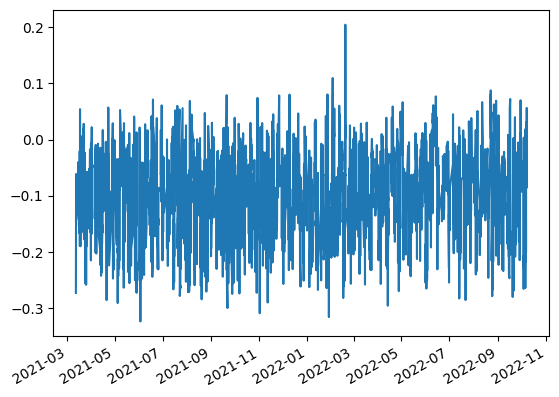

In [222]:
test_repr_il[2].plot()

In [176]:
results[TEST_ASSET][encoding_window]

# TODO: Result has same values for all keys
mean = 0
for key in results.keys():
    print(key, results[TEST_ASSET]['full_series'], results[TEST_ASSET]['net_compression'])
    mean += results[TEST_ASSET]['full_series'] < results[TEST_ASSET]['net_compression']

mean /= len(results.keys())
mean

PGR 0.4666666666666667 0.4696969696969697
WAT 0.4666666666666667 0.4696969696969697
BWA 0.4666666666666667 0.4696969696969697
LRCX 0.4666666666666667 0.4696969696969697
NWL 0.4666666666666667 0.4696969696969697
BLK 0.4666666666666667 0.4696969696969697
PPL 0.4666666666666667 0.4696969696969697


1.0

<AxesSubplot: xlabel='timestamp'>

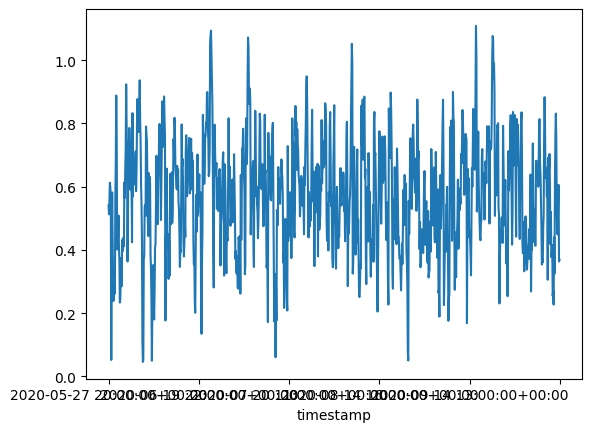

In [132]:
test_repr_il[0].plot()

In [ ]:
### TEST LOSS FUNCTIONS
BATCH_SIZE              = 100
rnn                     = nn.LSTM(5, 20, batch_first=True).float()
loss_test_values        = torch.from_numpy( train_data[:BATCH_SIZE] ).float()
output, (hn, cn)        = rnn(loss_test_values)
hn                      = hn.squeeze(0)
loss_test_exp_values    = torch.from_numpy( exp_train_data[:BATCH_SIZE]).float()

print( "quadratic_contrastive_loss: ", quadratic_contrastive_loss(hn, loss_test_exp_values, delta=1) )
print( "expclr_loss: ", expclr_loss(hn, loss_test_exp_values, delta=1) )

# max_diff = get_max_norm(batch_f)
# similarity_measure(batch_f[0], batch_f[1], max_diff)

In [ ]:
# out = model._eval_with_pooling(torch.from_numpy( test_data[:64] ).to(torch.float), None, encoding_window='')

In [51]:


# # # Load the ECG200 dataset from UCR archive
# train_data, train_labels, test_data, test_labels = datautils.load_ECG()
# # # (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)

# exp_feat = pd.DataFrame(  train_data.reshape(100, -1)[:,40:] )
# exp_feat = pd.DataFrame(  exp_feat.mean(axis=1) ).values


# # Train a TS2Vec model
# model = TS2Vec(
#     input_dims=1,
#     device=0,
#     output_dims=320
# )
# loss_log = model.fit(
#     train_data,
#     expert_features=exp_feat, #train_data.reshape(100, -1)[:,40:],
#     verbose=True
# )

# # Compute timestamp-level representations for test set
# test_repr_tl = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# # Compute instance-level representations for test set
# test_repr_il = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr_si = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])

Epoch #0: loss=2.3774041334788003
Epoch #1: loss=1.8855595191319783


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(test_repr_il)[4].plot()

In [ ]:
batch_xi     = torch.randn(32, 50)
batch_xj     = torch.randn(32, 50)
batch_f      = torch.randn(32, 10)


In [18]:

quadratic_contrastive_loss(batch_xi, batch_f, delta=1)

tensor(0.2878)

In [11]:
max_diff = get_max_norm(batch_f)


similarity_measure(batch_f[0], batch_f[1], max_diff)

tensor(0.0563)

In [71]:
expclr_loss(batch_xi, batch_f, delta=2)


tensor(0.1493)

In [63]:
from tensorflow.keras.layers import LSTM
import tensorflow as tf

inputs = tf.random.normal([5, 3, 10])
lstm = tf.keras.layers.LSTM(20)
output = lstm(inputs)
print(output.shape)


(5, 20)


In [90]:
rnn = nn.LSTM(10, 20, batch_first=True)
input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input)

In [184]:
hn.reshape(hn.shape[1:]).shape

torch.Size([5, 20])

In [91]:
print( output.shape )
print( hn.shape )
print( cn.shape )

torch.Size([5, 3, 20])
torch.Size([1, 5, 20])
torch.Size([1, 5, 20])


In [189]:
hn.squeeze(0)

torch.Size([5, 20])

In [181]:
output[:,-1:,:].reshape(5, 20).shape

torch.Size([5, 20])

In [120]:
output[:,-1:,:].reshape(5, 20) == hn.reshape(5, 20)

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])

In [7]:
# data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols = datautils.load_forecast_csv("ETTh2")
# train_data = data[:, train_slice]
        
# # Train a TS2Vec model
# model = TS2Vec(
#     input_dims=1,
#     device=0,
#     output_dims=320
# )
# loss_log = model.fit(
#     train_data,
#     verbose=True
# )

# # Compute timestamp-level representations for test set
# test_repr = model.encode(test_data)  # n_instances x n_timestamps x output_dims

# # Compute instance-level representations for test set
# test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

# # Sliding inference for test set
# test_repr = model.encode(
#     test_data,
#     casual=True,
#     sliding_length=1,
#     sliding_padding=50
# )  # n_instances x n_timestamps x output_dims
# # (The timestamp t's representation vector is computed using the observations located in [t-50, t])